# Pancancer Classifier
Here we train a XGB model to classify cancer types based on oncRNA signature.

In [1]:
import os
import pymongo
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import sklearn
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.feature_selection import SelectFromModel
import joblib
from xgboost import XGBClassifier
import xgboost 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Load Data

In [2]:
myclient=pymongo.MongoClient(port=27027)
mydb = myclient["TCGA_loci"]
rnacol = mydb["oncRNA_fil"]
rnacol.estimated_document_count()

261479

In [3]:
metadata = pd.read_csv("metadata/TCGA_metadata.csv")
cancer_metadata = metadata[(~metadata["Sample"].str.contains("normal"))] #Does not contain normal.
cancer_metadata = cancer_metadata.sort_values("TCGA_abb").reset_index(drop=True)
cancer_metadata.shape

(10403, 5)

In [4]:
cancer_metadata["Order"] = np.arange(10403)
cancer_metadata = cancer_metadata.set_index("TCGAbarcode", drop=False)
cancer_metadata.head(5)

,UUID,TCGAbarcode,TSS,Sample,TCGA_abb,Order
TCGAbarcode,,,,,,
TCGA-OR-A5K6-01A-11R-A29W-13,8fadd729-6bb7-42e1-96a2-75478f31ab68,TCGA-OR-A5K6-01A-11R-A29W-13,adrenocortical carcinoma,primary solid tumor,ACC,0
TCGA-OR-A5LM-01A-11R-A29W-13,a8705667-eac7-4345-94de-2dd311bbe53b,TCGA-OR-A5LM-01A-11R-A29W-13,adrenocortical carcinoma,primary solid tumor,ACC,1
TCGA-OR-A5KZ-01A-11R-A29W-13,39b0086f-3646-4cea-a31c-84e3075ad53e,TCGA-OR-A5KZ-01A-11R-A29W-13,adrenocortical carcinoma,primary solid tumor,ACC,2
TCGA-OR-A5J9-01A-11R-A29W-13,6e842278-c925-4ce2-bdac-9a68c3c1761b,TCGA-OR-A5J9-01A-11R-A29W-13,adrenocortical carcinoma,primary solid tumor,ACC,3
TCGA-OR-A5J1-01A-11R-A29W-13,18c9affc-e499-4093-ac8a-5cb274a901aa,TCGA-OR-A5J1-01A-11R-A29W-13,adrenocortical carcinoma,primary solid tumor,ACC,4


In [5]:
cancer_dict_order = dict(zip(cancer_metadata["TCGAbarcode"], cancer_metadata["Order"]))

In [6]:
%%time
data = np.zeros((10403, 261479))
oncRNA_list = []
cursor = rnacol.find(no_cursor_timeout=True)
j = 0
for rna in cursor:
    locus = rna["_id"]["locus"]
    oncRNA_list.append(locus)
    for s in rna["samples"]:
        if "normal" in s["sample type"]: #Only keeping cancer samples. Ignoring normal samples.
            continue
        else:
            barcode = s["study"]
            i = cancer_dict_order[barcode]
            data[i,j] = s["cpm"]
    j += 1
cursor.close()

CPU times: user 2min 49s, sys: 22.8 s, total: 3min 12s
Wall time: 3min 20s


In [7]:
myclient.close()

In [8]:
data = coo_matrix(data)

In [9]:
ylabels = np.array(cancer_metadata["TCGA_abb"])

In [10]:
X_full_train, X_test, y_full_train, y_test = train_test_split(data, ylabels, test_size = 0.2, random_state=47, stratify=ylabels)
X_full_train.shape, X_test.shape

((8322, 261479), (2081, 261479))

# Feature Selection with Cross-fold Validation

In [11]:
fold_threshold_scores = {}
fold_feature_importance_map = {}
fold_X_train = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
k = 1
for train_index, val_index in skf.split(X_full_train,y_full_train):
    X_train, X_val = X_full_train[train_index], X_full_train[val_index]
    y_train, y_val = y_full_train[train_index], y_full_train[val_index]
    fold_X_train[k] = X_train
    #Create class weights for the train data.
    labels = np.unique(y_train)  #np.unqiue sorts values
    class_weights = class_weight.compute_class_weight("balanced", labels, y_train)
    class_weight_map = {}
    for i in range(len(labels)):
        class_weight_map[labels[i]] = class_weights[i] 
    
    sample_weights = []
    for y in y_train:
        sample_weights.append(class_weight_map[y])
        
    xgb_model = XGBClassifier(n_jobs=20, silent=False,n_estimators=500, random_state=19, max_depth=3)
    xgb_model.fit(X_train, y_train, sample_weight=sample_weights)
    
    threshold_scores = {}
    thresholds = np.sort(xgb_model.feature_importances_)
    thresholds = list(set(np.round(thresholds, 4)))
    thresholds = thresholds[1:] #Skip the 0 threshold, we have that already in XGB
    
    for thresh in sorted(thresholds):
        #Select features using threshold
        selection = SelectFromModel(xgb_model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        #Got an error here. Since rounding, it is possible that we get no select_X_train features as threshold is too high. Leads to error
        if select_X_train.shape[1] == 0:
            continue

        #Validation
        selection_model = XGBClassifier(n_jobs=20, silent=False,n_estimators=500, random_state=20, max_depth=3)
        select_X_val = selection.transform(X_val)
        selection_model.fit(select_X_train, y_train, sample_weight=sample_weights)
        
        y_pred = selection_model.predict(select_X_val)
        acc = accuracy_score(y_val, y_pred)        
        threshold_scores[thresh] = acc
        
    
    fold_threshold_scores[k] = threshold_scores
    fold_feature_importance_map[k] = xgb_model.feature_importances_
    out = f'models/XGB_models/{k}th_fold_500_trees_xgb.pkl'
    joblib.dump(xgb_model, out) 
    
    print(f"Finish Fold {k}")
    k += 1

[17:37:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:51:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:51:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only u

/rumi/shams/jwang/anaconda3/envs/smRNA/lib/python3.7/site-packages/sklearn/feature_selection/_base.py:81: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)


Finish Fold 1
[17:57:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:11:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:11:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some paramet

# Here

In [12]:
def thresh2N(row, k):
    return len([x for x in fold_feature_importance_map[k] if x >= row])

In [13]:
fold_threshold_results = {}
for k in range(1, 6):
    threshold_results = pd.DataFrame.from_dict(fold_threshold_scores[k], orient="index").reset_index().rename(columns={"index": "Threshold", 0:"Accuracy"})
    threshold_results["N"] = threshold_results["Threshold"].apply(thresh2N, args=(k,))
    fold_threshold_results[k] = threshold_results

In [14]:
for k in range(1, 6):
    fold_threshold_results[k].to_csv(f"models/XGB_models/{k}th_threshold_results.csv")

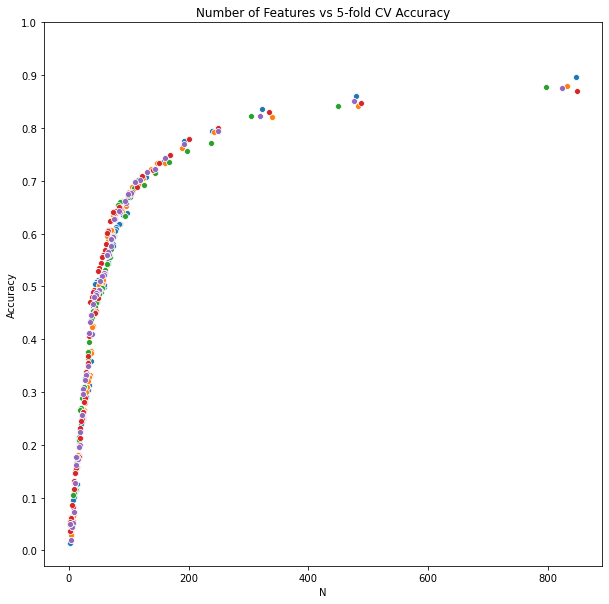

In [15]:
plt.figure(figsize=(10,10))
for k in range(1, 6): 
    sns.scatterplot(data=fold_threshold_results[k], x="N", y="Accuracy")
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title("Number of Features vs 5-fold CV Accuracy")
plt.savefig("figures/Threshold_features_5CV_acc.pdf")

In [16]:
fold_threshold_results[4]

,Threshold,Accuracy,N
0,0.0001,0.869591,849
1,0.0002,0.846755,489
2,0.0003,0.829928,334
3,0.0004,0.799279,249
4,0.0005,0.778846,201
...,...,...,...
69,0.0236,0.085938,5
70,0.0278,0.060697,3
71,0.0337,0.060697,3
72,0.0839,0.054688,2


In [17]:
feature_indices = set()
th =  0.00015
for k in range(1,6):
    f_importances = fold_feature_importance_map[k]
    for i in range(len(f_importances)):
        if f_importances[i] >= th:
            feature_indices.add(i)
len(feature_indices)

1863

# Final Evaluation

In [18]:
labels = np.unique(y_full_train)  #np.unqiue sorts values
class_weights = class_weight.compute_class_weight("balanced", labels, y_full_train)
class_weight_map = {}
for i in range(len(labels)):
    class_weight_map[labels[i]] = class_weights[i] 

sample_weights = []
for y in y_full_train:
    sample_weights.append(class_weight_map[y])

In [19]:
imp_X_train = X_full_train[:, list(feature_indices)]
imp_X_train.shape

(8322, 1863)

In [20]:
selection_model = XGBClassifier(n_jobs=20, silent=False,n_estimators=500, max_depth=3, reg_lambda=8)
selection_model.fit(imp_X_train, y_full_train)

[20:18:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=20, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=8, scale_pos_weight=None, silent=False, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
y_pred = selection_model.predict(imp_X_train)
acc = accuracy_score(y_full_train, y_pred)
acc

1.0

In [22]:
final_X_test = X_test[:, list(feature_indices)]
y_pred = selection_model.predict(final_X_test)
acc = accuracy_score(y_test, y_pred)
acc

0.9077366650648726

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ACC       0.94      1.00      0.97        16
        BLCA       0.84      0.79      0.81        84
        BRCA       0.90      0.98      0.94       221
        CESC       0.88      0.68      0.76        62
        CHOL       1.00      0.71      0.83         7
        COAD       0.81      0.92      0.86        92
        DLBC       0.78      0.78      0.78         9
        ESCA       0.90      0.73      0.81        37
        HNSC       0.82      0.89      0.85       105
        KICH       1.00      0.92      0.96        13
        KIRC       0.92      0.96      0.94       109
        KIRP       0.95      0.90      0.92        58
        LAML       1.00      0.92      0.96        38
         LGG       1.00      0.99      1.00       106
        LIHC       0.97      0.93      0.95        75
        LUAD       0.85      0.84      0.84       104
        LUSC       0.74      0.80      0.77        96
        MESO       0.93    

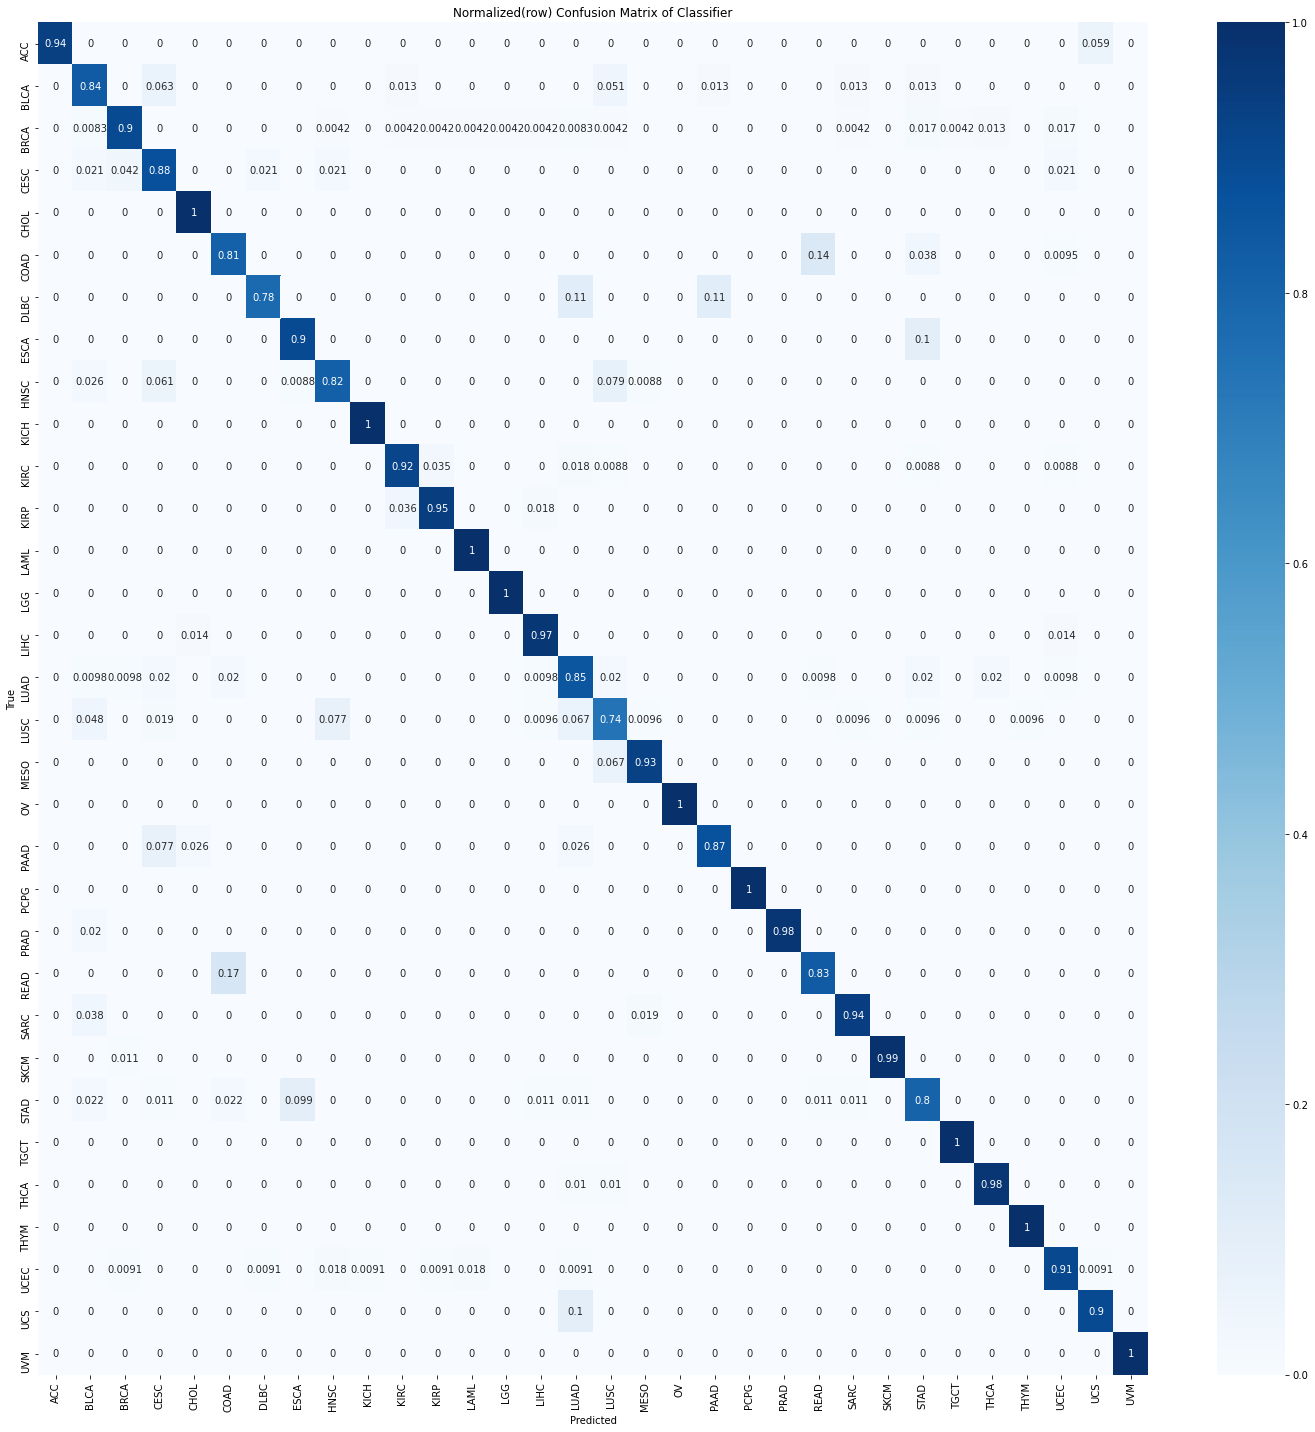

In [24]:
row_norm_cm = confusion_matrix(y_pred, y_test, labels=labels, normalize="true") #Normalizes by True rows (measure of precision)
plt.figure(figsize=(20,20))
sns.heatmap(row_norm_cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized(row) Confusion Matrix of Classifier")
plt.tight_layout()
plt.savefig("figures/pancancer_row_cm.pdf");

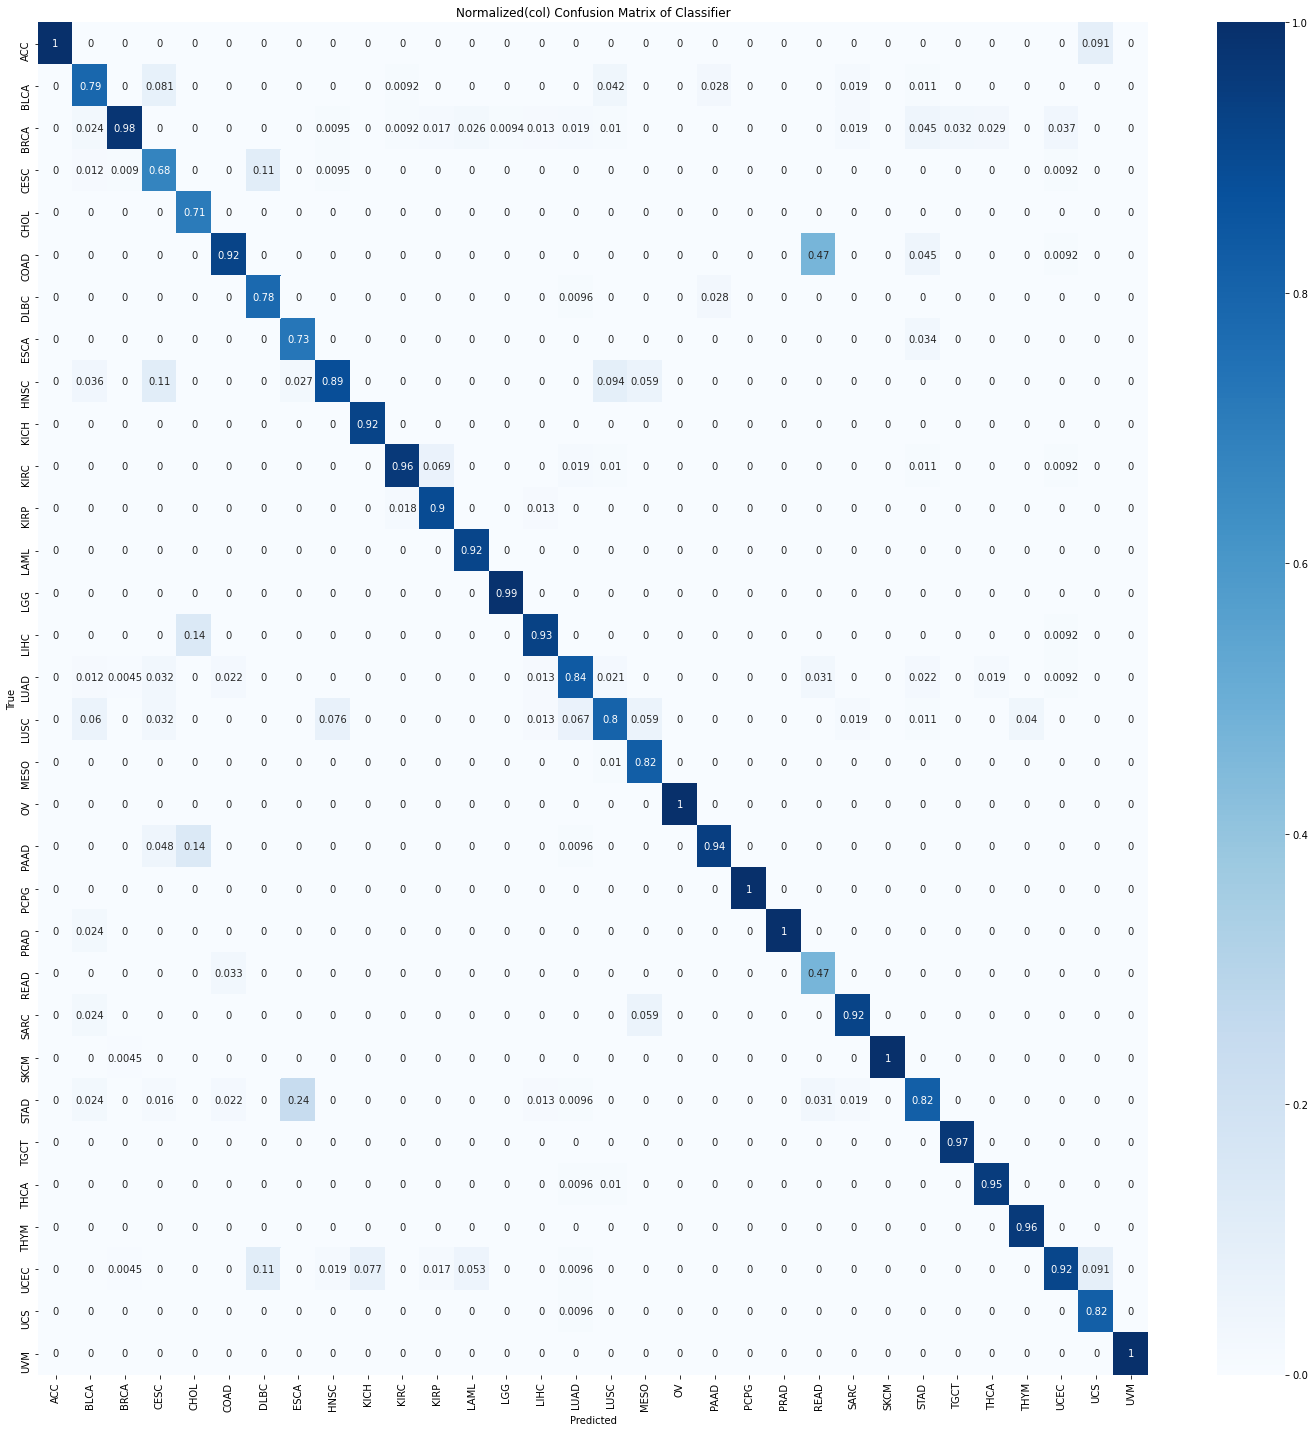

In [25]:
col_norm_cm = confusion_matrix(y_pred, y_test,labels=labels, normalize="pred") #Normalizes by Predicted columns (measure of recall)
plt.figure(figsize=(20,20))
sns.heatmap(col_norm_cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized(col) Confusion Matrix of Classifier")
plt.tight_layout()
plt.savefig("figures/pancancer_col_cm.pdf");

## Save features:

In [26]:
with open("models/feature_list.txt", "w") as out:   
    for i in feature_indices:
        out.write(oncRNA_list[i] + "\n")

# Done